In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("..")

from utils.funciones_toolbox_ml_final import *
from utils.modulos import *

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, recall_score, balanced_accuracy_score, make_scorer, silhouette_score, silhouette_samples
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Problema de negocio

- Identificar a los pacientes que tienen Síndrome Metabólico

## Objetivo técnico

El síndrome metabólico es un conjunto de condiciones médicas que aumentan el riesgo de enfermedades cardiovasculares, diabetes tipo 2 y otros problemas de salud. Estas condiciones incluyen hipertensión arterial, niveles altos de azúcar en la sangre, exceso de grasa abdominal y niveles anormales de colesterol o triglicéridos en la sangre, por lo que se nos pide:

**Identificar a las personas en riesgo para crear posteriormente programas de salud e intervenciones preventivas y personalizadas para éstos pacientes**

## Métricas

 - El recall de la clase 1 sería la métrica adecuada para evaluar qué tan bien el modelo identifica a todos los pacientes que tienen el síndrome metabólico, donde la clase positiva representa a los pacientes enfermos (clase 1). Al establecer el recall como la métrica objetivo, se prioriza la capacidad del modelo para detectar a todos los pacientes con síndrome metabólico. Esto asegura que el modelo esté optimizado para capturar la mayor cantidad posible de casos positivos, lo que es crucial para identificar a las personas en riesgo y proporcionarles la atención médica adecuada.

## Obtención de los datos

In [2]:
df = pd.read_csv("../data/MetabolicSyndrome.csv")
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 281.5+ KB


In [4]:
describe_df(df)

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
Tipo,int64,int64,object,object,float64,object,float64,float64,int64,float64,float64,int64,int64,int64,int64
Porcentaje_Nulos,0.0,0.0,0.0,8.663057,4.87297,0.0,3.540192,1.082882,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valores_Unicos,2401,61,2,5,14,6,635,322,3,1383,88,187,93,345,2
Porcentaje_Cardinalidad,100.0,2.540608,0.083299,0.208247,0.58309,0.249896,26.447314,13.411079,0.124948,57.601,3.66514,7.788421,3.873386,14.369013,0.083299


In [5]:
tabla_descriptiva = tipifica_variables(df,10,30)
tabla_descriptiva

,nombre_variable,tipo_sugerido
0,seqn,Numerica Continua
1,Age,Numerica Discreta
2,Sex,Binaria
3,Marital,Categorica
4,Income,Numerica Discreta
5,Race,Categorica
6,WaistCirc,Numerica Discreta
7,BMI,Numerica Discreta
8,Albuminuria,Categorica
9,UrAlbCr,Numerica Continua


In [6]:
descripcion = {"Descripcion":["Índice único", "Edad", "Género", 
                              "Estado civil","Ingresos", "Raza",
                              "Circunferencia Abdominal", "Índice de Masa Corporal",
                              "Medida de Albumina en orina", "Relación Albumina-Creatitina en orina",
                              "Ácido Úrico", "Azúcar en sangre", 
                              "Niveles de colesterol de lipoproteínas de alta densidad('colesterol bueno')",
                              "Triglicéridos", "Indica la presencia (1) o ausencia (0) de síndrome metabólico"
                              ]}
df_descripcion = pd.DataFrame(descripcion)

tabla_descriptiva = pd.concat([tabla_descriptiva, df_descripcion], axis=1)

In [7]:
tabla_descriptiva
tabla_descriptiva

,nombre_variable,tipo_sugerido,Descripcion
0,seqn,Numerica Continua,Índice único
1,Age,Numerica Discreta,Edad
2,Sex,Binaria,Género
3,Marital,Categorica,Estado civil
4,Income,Numerica Discreta,Ingresos
5,Race,Categorica,Raza
6,WaistCirc,Numerica Discreta,Circunferencia Abdominal
7,BMI,Numerica Discreta,Índice de Masa Corporal
8,Albuminuria,Categorica,Medida de Albumina en orina
9,UrAlbCr,Numerica Continua,Relación Albumina-Creatitina en orina


- Voy a eliminar las columnas que no me aportan nada a la hora de realizar el modelo, "seqn" porque es un índice de los pacientes y tiene una cardinalidad del 100%, y elimino "UrAlbCr" porque aporta la misma información que Albuminuria.

In [8]:
df.drop(columns=["seqn", "UrAlbCr"], inplace= True)

In [9]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

- Hay 4 columnas con valores nulos, de las cuales "Marital" es la única categórica.

In [10]:
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,2954.032186,16.252634,6.662242,0.422780,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


In [11]:
# Verificamos que no hayan duplicados
print(df.duplicated().sum())

0


## Mini EDA

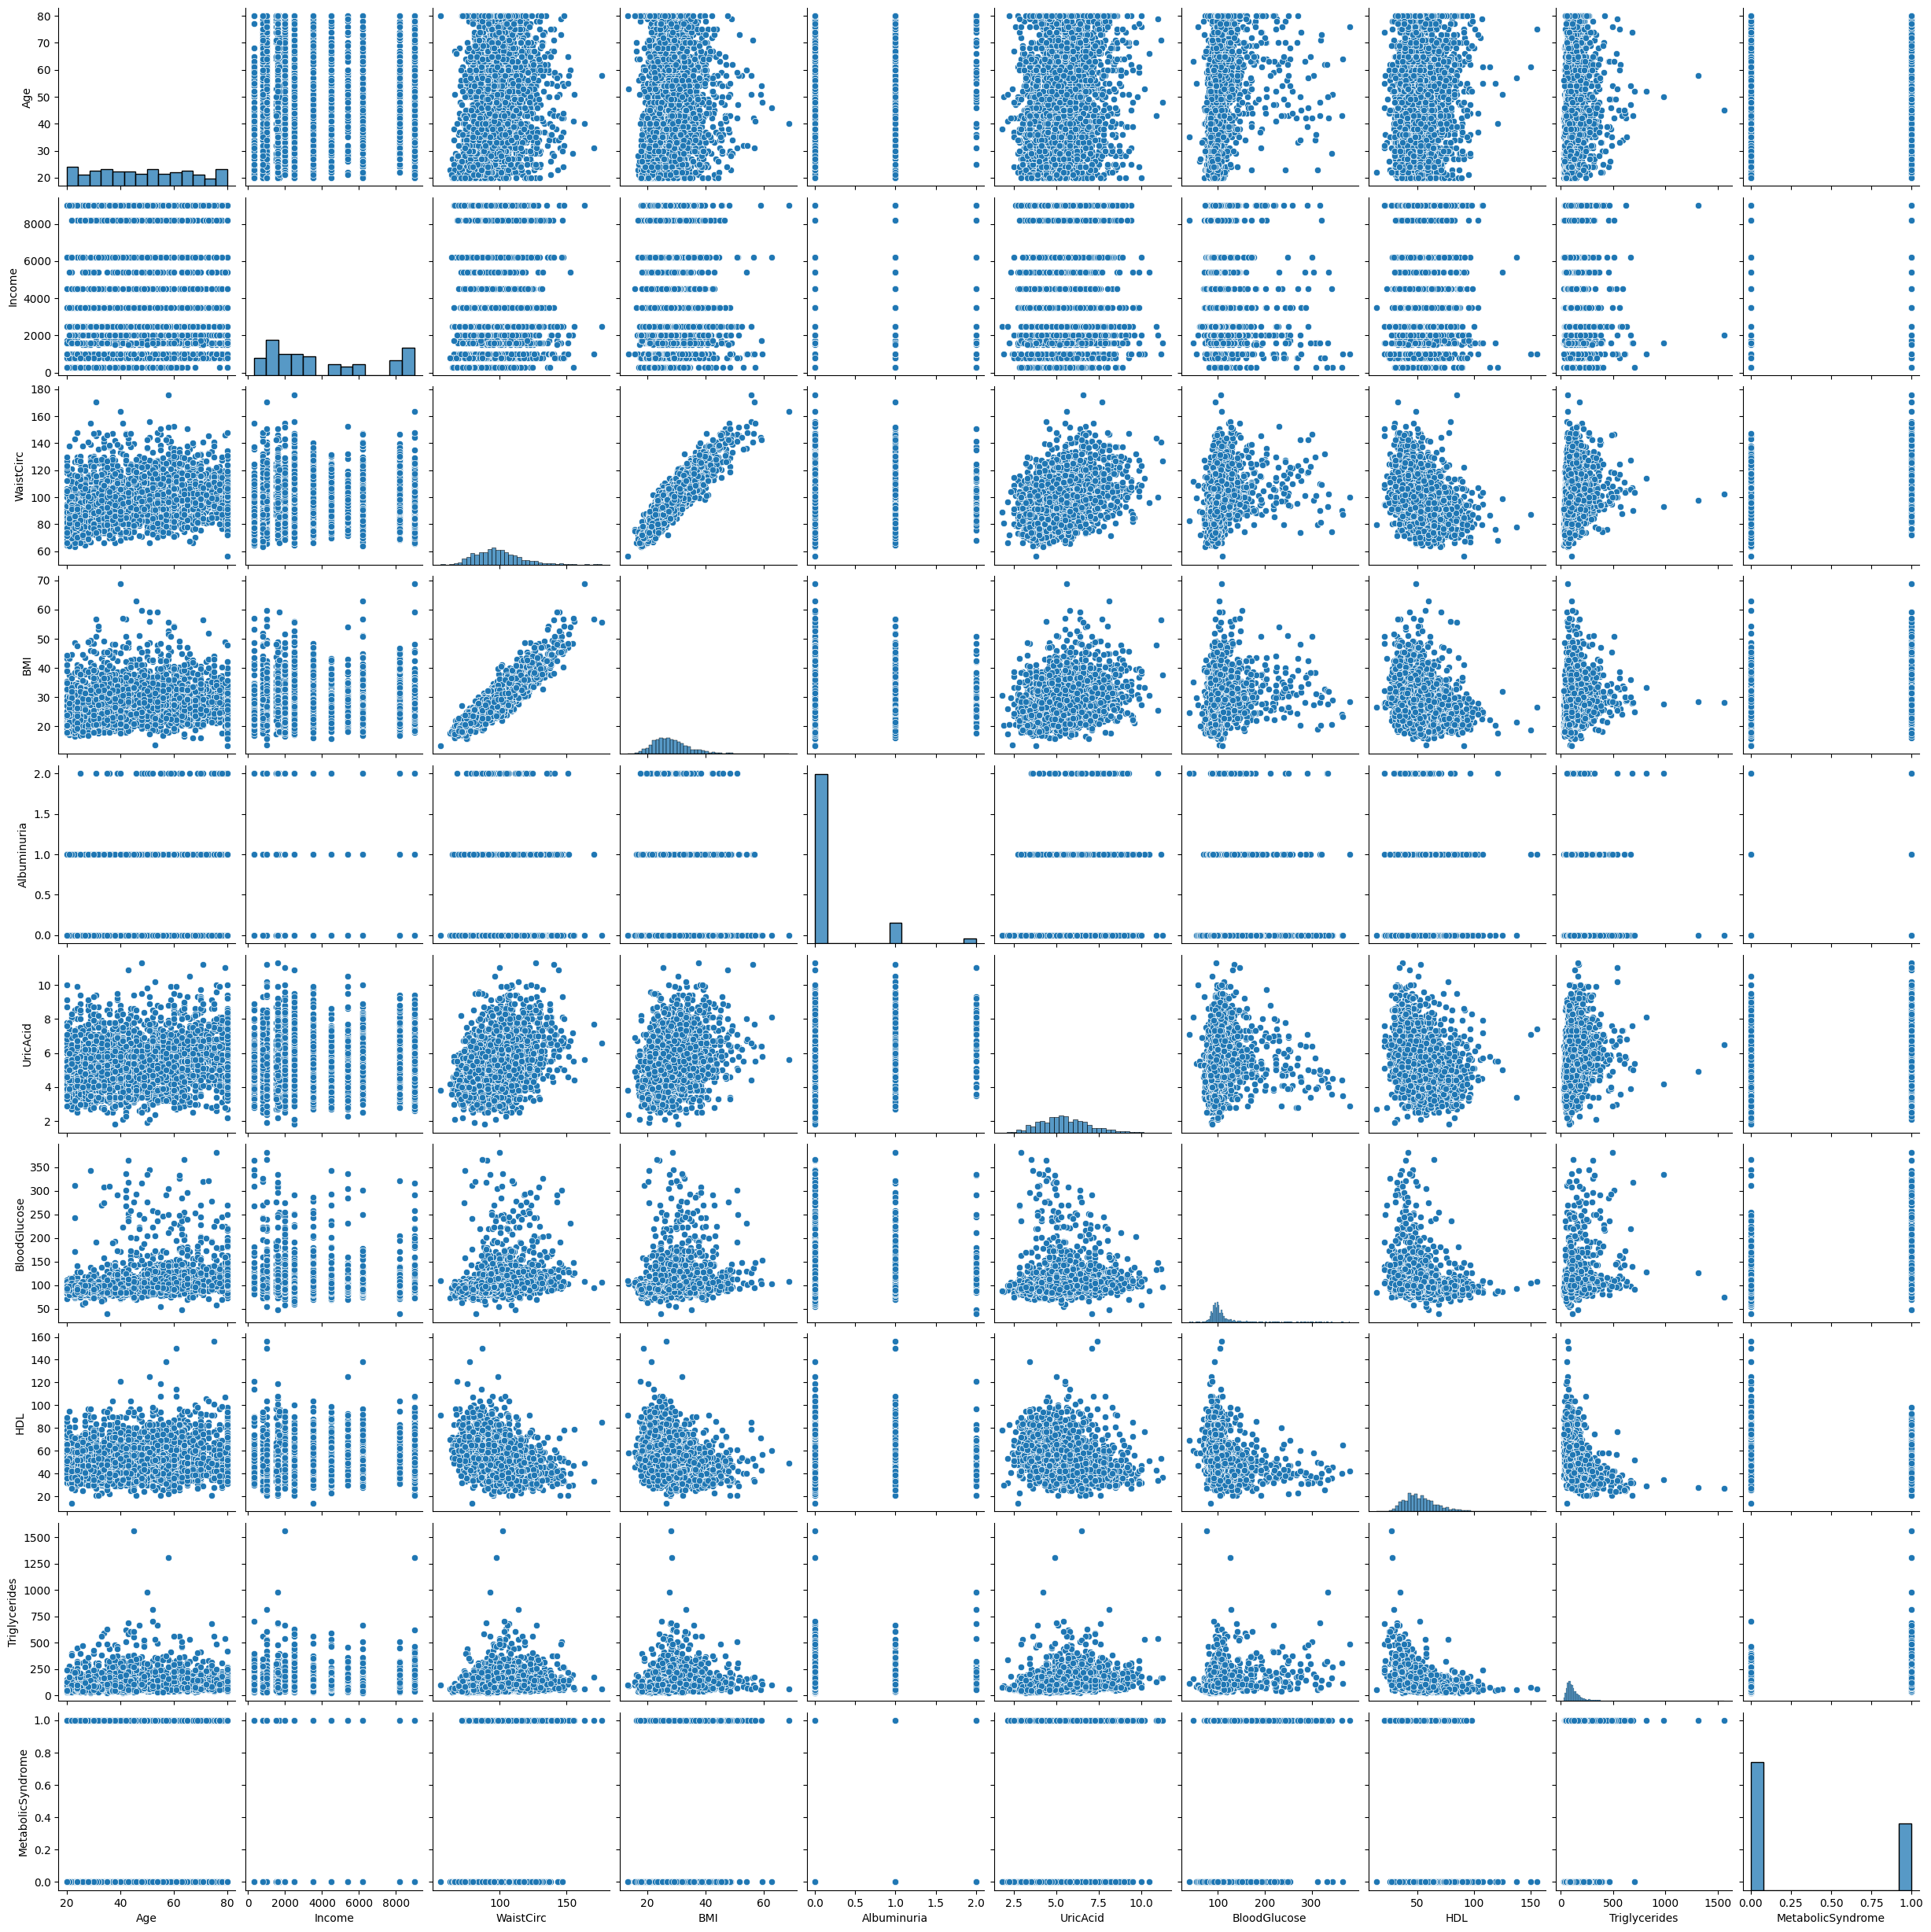

In [12]:
sns.pairplot(df)

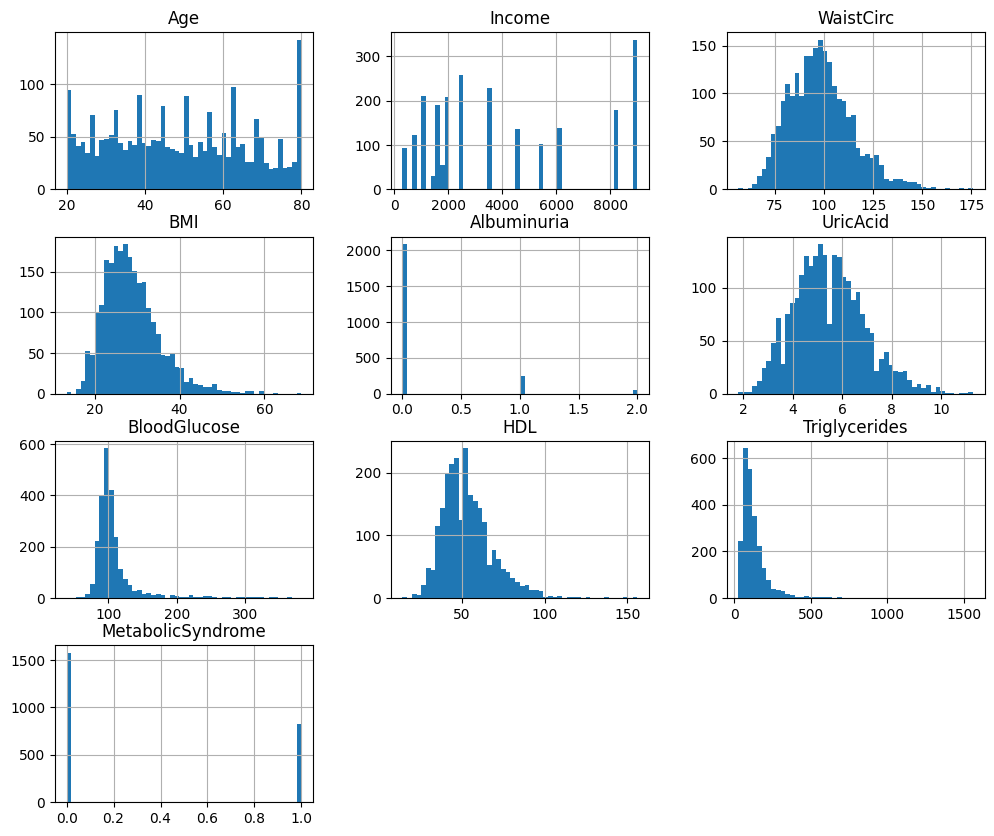

In [13]:
df.hist(bins=50, figsize=(12, 10))
plt.show()

- Voy a empezar por imputar nulos a las columnas:

    - Marital: Moda
    - Income: Media
    - WaistCirc: Media
    - BMI:Media                   

In [14]:
waist_circ_media = df["WaistCirc"].mean()
bmi_media = df["BMI"].mean()
income_media = df["Income"].mean()
race_moda = df["Race"].mode()[0]
df["WaistCirc"].fillna(waist_circ_media, inplace=True)
df["BMI"].fillna(waist_circ_media, inplace=True)
df["Income"].fillna(income_media, inplace = True)
df["Race"].fillna(race_moda, inplace = True)

## Procesado de Features

In [15]:
df_original = df.copy()

#### Tratamiento de las features categóricas

In [16]:
le = LabelEncoder()
columns_to_encode = ["Marital", "Race", "Sex"]

encoded_values = {}
for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])
    encoded_values[column] = dict(zip(le.transform(le.classes_), le.classes_))


## Obtención de K

#### Método del codo

In [17]:
ks = []
inertias = []

for k in range(1, 10):
    clustering = KMeans(n_clusters = k)
    clustering.fit(df)
    inertias.append(clustering.inertia_)
    ks.append(k)

In [18]:
df_inertias = pd.DataFrame({'k': ks, 'inertia': inertias})
df_inertias

,k,inertia
0,1,1.994904e+10
1,2,3.975072e+09
2,3,1.390766e+09
3,4,7.787191e+08
4,5,3.637942e+08
5,6,2.762571e+08
6,7,2.017036e+08
7,8,1.303733e+08
8,9,9.262494e+07


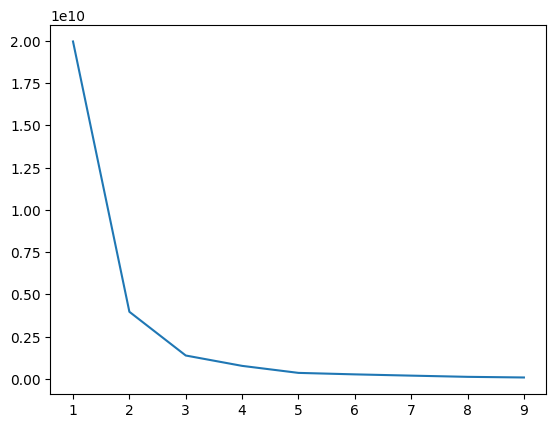

In [19]:
plt.plot(ks, inertias);

- Aunque no esta muy claro podemos considerar quedarnos con k=2

#### Score de Silueta

In [20]:
ks = []
sil_scores = []

for k in range(2, 10): 
    clustering = KMeans(n_clusters = k)
    clustering.fit(df)

    sil_scores.append(silhouette_score(df, clustering.labels_))
    ks.append(k)

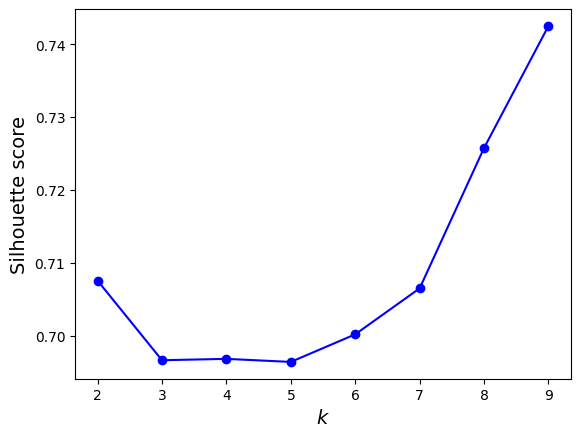

In [21]:
plt.plot(ks, sil_scores, "bo-");
plt.xlabel("$k$", fontsize=14);
plt.ylabel("Silhouette score", fontsize=14);

- Podemos confirmar que el mejor valor de k sería el 2

#### Diagrama de Silueta

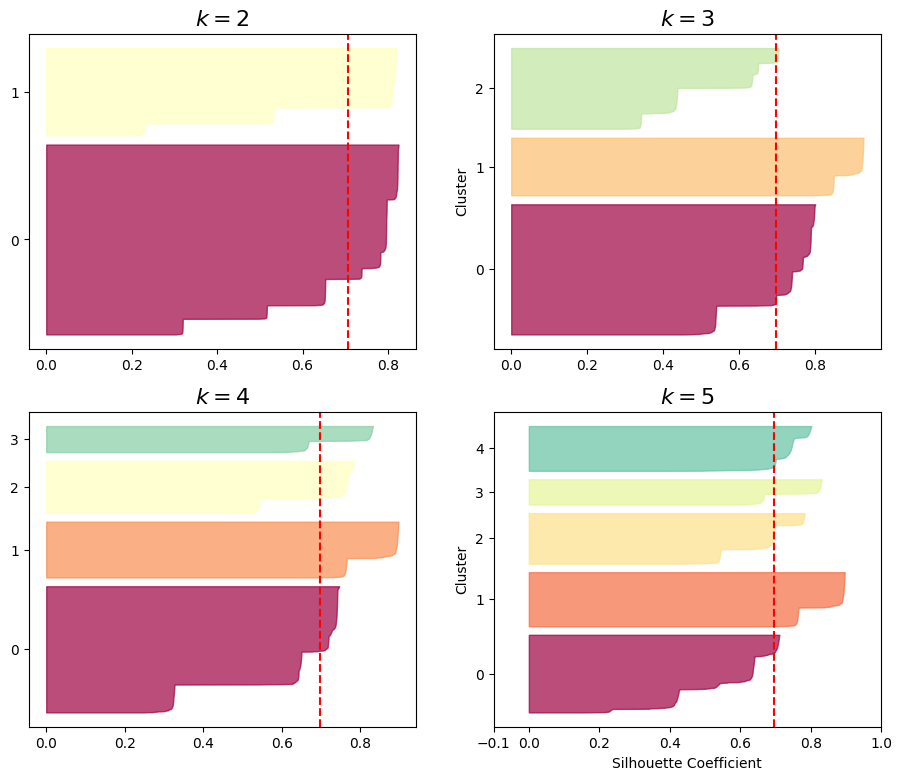

In [22]:

from matplotlib.ticker import FixedLocator, FixedFormatter

'''
La anchura de cada cuchillo representa el numero de muestras por cluster. Están ordenadas
por su coeficiente de silhouette, por eso tiene esa forma de cuchillo. Cuanta más caida tenga
indica que las muestras tienen un coeficiente mas disperso en ese cluster
Deberian estar todos los clusters por encima de la media.
Hay algunas lineas hacia la izda xq es el coeficiente negativo. Puntos asignados al cluster erroneo.
'''
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    clustering = KMeans(n_clusters = k)
    clustering.fit(df)
    y_pred = clustering.labels_
    silhouette_coefficients = silhouette_samples(df, y_pred)

    padding = len(df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=sil_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

- Todos cumplen la condición de superar el score de silueta, sin embargo el k=2 los grupos parecen ser más parecidos y no hay valores negativos, en cambio en los otros "k" casi todos los grupos tienen negativo.
- Nos quedamos con k=2

### Modelado

In [23]:
clustering = KMeans(n_clusters= 2)
clustering.fit(df)

KMeans(n_clusters=2)

In [24]:
df_original['cluster'] = clustering.predict(df)
df_original.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,cluster
0,22,Male,Single,8200.00000,White,81.0,23.3,0,4.9,92,41,84,0,1
1,44,Female,Married,4500.00000,White,80.1,23.2,0,4.5,82,28,56,0,0
2,21,Male,Single,800.00000,Asian,69.6,20.1,0,5.4,107,43,78,0,0
3,43,Female,Single,2000.00000,Black,120.4,33.3,0,5.0,104,73,141,0,0
4,51,Male,Married,4005.25394,Asian,81.1,20.1,0,5.0,95,43,126,0,0


In [25]:
df_original['cluster'].value_counts(normalize= True)

cluster
0    0.685131
1    0.314869
Name: proportion, dtype: float64

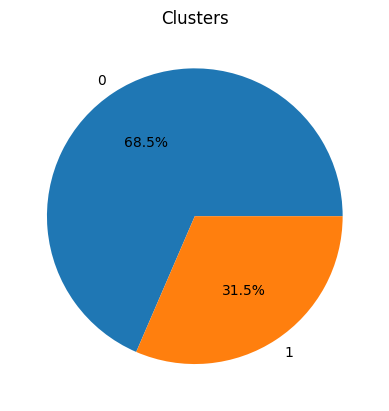

In [26]:
plt.pie(df_original['cluster'].value_counts(normalize= True), autopct= '%1.1f%%', labels= ['0', '1'])
plt.title('Clusters');

In [27]:
df_cluster_0 = df_original[df_original['cluster']==0]
df_cluster_1 = df_original[df_original['cluster']==1]

In [28]:
df_cluster_0.describe(include='all')

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,cluster
count,1645.000000,1645,1467,1645.000000,1645,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000,1645.0
unique,NaN,2,5,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Female,Married,NaN,White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,838,651,NaN,612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,49.042553,NaN,NaN,2256.665478,NaN,98.841012,29.801912,0.179939,5.483587,110.066869,52.722188,130.227356,0.361702,0.0
std,18.573374,NaN,NaN,1230.194467,NaN,16.176369,10.189289,0.452580,1.453270,36.991357,15.018805,97.707621,0.480639,0.0
min,20.000000,NaN,NaN,300.000000,NaN,56.200000,13.400000,0.000000,1.800000,47.000000,14.000000,26.000000,0.000000,0.0
25%,32.000000,NaN,NaN,1000.000000,NaN,87.300000,24.200000,0.000000,4.500000,93.000000,42.000000,75.000000,0.000000,0.0
50%,49.000000,NaN,NaN,2000.000000,NaN,98.307254,28.000000,0.000000,5.400000,100.000000,51.000000,105.000000,0.000000,0.0
75%,65.000000,NaN,NaN,3500.000000,NaN,108.100000,32.800000,0.000000,6.400000,111.000000,61.000000,151.000000,1.000000,0.0


In [29]:
df_cluster_1.describe(include='all')

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,cluster
count,756.000000,756,726,756.000000,756,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.0
unique,NaN,2,5,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,Married,NaN,White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,383,541,NaN,321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,47.928571,NaN,NaN,7810.052910,NaN,97.145836,28.703100,0.097884,5.500926,104.289683,54.777778,123.551587,0.300265,1.0
std,15.372985,NaN,NaN,1390.718333,NaN,15.432867,8.814905,0.342868,1.409490,29.184854,15.458754,89.807085,0.458676,0.0
min,20.000000,NaN,NaN,5400.000000,NaN,64.200000,16.900000,0.000000,2.300000,39.000000,21.000000,26.000000,0.000000,1.0
25%,36.000000,NaN,NaN,6200.000000,NaN,86.000000,23.700000,0.000000,4.500000,91.000000,44.000000,73.000000,0.000000,1.0
50%,47.000000,NaN,NaN,8200.000000,NaN,96.500000,27.500000,0.000000,5.400000,98.000000,52.000000,99.000000,0.000000,1.0
75%,60.000000,NaN,NaN,9000.000000,NaN,105.400000,31.300000,0.000000,6.500000,107.000000,63.250000,146.000000,1.000000,1.0


In [30]:
df_cluster_0.drop(columns="cluster",inplace=True)
df_cluster_1.drop(columns="cluster", inplace= True)

In [31]:
encoded_values = {}
for column in columns_to_encode:
    df_cluster_0[column] = le.fit_transform(df_cluster_0[column])
    encoded_values[column] = dict(zip(le.transform(le.classes_), le.classes_))


In [32]:
encoded_values = {}
for column in columns_to_encode:
    df_cluster_1[column] = le.fit_transform(df_cluster_1[column])
    encoded_values[column] = dict(zip(le.transform(le.classes_), le.classes_))

In [33]:
train_set_0, test_set_0 = train_test_split(df_cluster_0, test_size=0.2,random_state=73)
train_set_1, test_set_1 = train_test_split(df_cluster_1, test_size=0.2,random_state=73)

In [34]:
X_train_0= train_set_0.drop(columns="MetabolicSyndrome")
y_train_0 = train_set_0["MetabolicSyndrome"]
X_test_0= test_set_0.drop(columns="MetabolicSyndrome")
y_test_0 = test_set_0["MetabolicSyndrome"]

In [35]:
X_train_1= train_set_1.drop(columns="MetabolicSyndrome")
y_train_1 = train_set_1["MetabolicSyndrome"]
X_test_1= test_set_1.drop(columns="MetabolicSyndrome")
y_test_1 = test_set_1["MetabolicSyndrome"]

In [36]:
pt = PowerTransformer()
X_train_0[X_train_0.columns]=pt.fit_transform(X_train_0[X_train_0.columns])
X_test_0[X_test_0.columns]=pt.transform(X_test_0[X_test_0.columns])

In [37]:
X_train_1[X_train_1.columns]=pt.fit_transform(X_train_1[X_train_1.columns])
X_test_1[X_test_1.columns]=pt.transform(X_test_1[X_test_1.columns])

In [38]:
X_train_0

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides
2359,-1.418190,1.024619,0.701084,1.605939,-0.330905,-1.373290,-1.280950,-0.419583,0.698243,-0.413621,-0.597924,-0.084266
2119,-1.145123,1.024619,0.701084,-2.016677,-0.330905,-0.500719,0.095573,-0.419583,-1.031306,-0.684462,0.021692,0.926401
1439,0.633058,-0.975972,0.701084,1.605939,-0.330905,-0.078846,0.066252,-0.419583,0.110122,-1.627146,1.951513,-0.594477
2384,-0.887778,1.024619,-1.729825,1.315072,0.185662,-0.529194,-0.071006,-0.419583,0.312918,-0.230044,0.161216,-0.373824
2236,0.633058,1.024619,0.701084,1.315072,1.099659,-1.432502,-1.881111,-0.419583,0.110122,-0.230044,1.063329,-2.121292
...,...,...,...,...,...,...,...,...,...,...,...,...
459,-0.353525,1.024619,1.580804,0.311674,1.099659,-0.026922,-0.268715,-0.419583,-2.954192,-0.832474,-1.672751,1.818210
2066,0.081273,1.024619,-0.616278,-1.028647,1.099659,0.181670,0.006344,-0.419583,0.760051,1.383860,-2.719452,2.360411
561,0.185197,-0.975972,-1.729825,1.315072,1.099659,-0.244698,0.181110,-0.419583,-1.853358,-1.072293,-0.274779,-0.621053
203,0.337927,-0.975972,-0.616278,1.605939,-0.330905,0.573910,0.341982,-0.419583,-0.393428,2.365395,0.729355,1.483166


In [39]:
y_train_0

2359    0
2119    0
1439    0
2384    0
2236    0
       ..
459     1
2066    1
561     1
203     1
1318    0
Name: MetabolicSyndrome, Length: 1316, dtype: int64

In [40]:
model_names = ["Logistic Regression","Arbol de Decision","Random Forest","XGBoost","LightGBM","Catboost", "SVC", "KNN"]
rf_clf = RandomForestClassifier(random_state= 42, class_weight= "balanced")
xgb_clf = XGBClassifier(verbosity= 0, random_state = 42, scale_pos_weight=70/30)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100, class_weight= 'balanced')
lg_clf = LogisticRegression(max_iter = 10000, class_weight= 'balanced')
cat_clf = CatBoostClassifier(random_state= 42, verbose= False, auto_class_weights='Balanced')
tree_clf = DecisionTreeClassifier(random_state= 42, class_weight= "balanced")
svc = SVC(random_state= 42, class_weight='balanced')
knn_clf = KNeighborsClassifier(n_neighbors= 4)

model_set = [rf_clf, xgb_clf, lgb_clf,lg_clf,cat_clf,tree_clf,svc, knn_clf]

scorer = make_scorer(recall_score, pos_label=1)

In [41]:
#Hacemos un CrossValidation con varios modelos y el dataset del grupo 0
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    metricas_cv[nombre] = cross_val_score(modelo, X_train_0, y_train_0, cv = 5, scoring = scorer)
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

RandomForestClassifier(class_weight='balanced', random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(class_weight='balanced', random_state=42, verbose=-100)
LogisticRegression(class_weight='balanced', max_iter=10000)
DecisionTreeClassifier(class_weight='balanced', 

In [42]:
data= []
for model_name, valores in metricas_cv.items():
    data.append({'Modelo': model_name, 'Recall_CV': np.mean(valores)})


df = pd.DataFrame(data)


print(df)
print(f"El ganador es {ganador}")

                Modelo  Recall_CV
0  Logistic Regression   0.788772
1    Arbol de Decision   0.832654
2        Random Forest   0.843070
3              XGBoost   0.847237
4             LightGBM   0.859781
5             Catboost   0.776075
6                  SVC   0.849298
7                  KNN   0.558618
El ganador es LightGBM


In [43]:
y_train_1

1569    0
2004    1
1758    1
231     0
1021    1
       ..
1073    1
1081    0
1288    0
1302    1
508     0
Name: MetabolicSyndrome, Length: 604, dtype: int64

In [44]:
#Hacemos un CrossValidation con varios modelos y el dataset del grupo 1 
metricas_cv_1= {}
valores_1= []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    metricas_cv_1[nombre] = cross_val_score(modelo, X_train_1, y_train_1, cv = 5, scoring = scorer)
    valores_1.append(np.mean(metricas_cv_1[nombre]))
ganador = list(metricas_cv_1.keys())[np.argmax(valores_1)]

RandomForestClassifier(class_weight='balanced', random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(class_weight='balanced', random_state=42, verbose=-100)
LogisticRegression(class_weight='balanced', max_iter=10000)
DecisionTreeClassifier(class_weight='balanced', 

In [45]:
data_1= []
for model_name, valores_1 in metricas_cv_1.items():
    data_1.append({'Modelo': model_name, 'Recall_CV': np.mean(valores_1)})


df_1 = pd.DataFrame(data_1)


print(df_1)
print(f"El ganador es {ganador}")

                Modelo  Recall_CV
0  Logistic Regression   0.770385
1    Arbol de Decision   0.806538
2        Random Forest   0.832179
3              XGBoost   0.862564
4             LightGBM   0.867692
5             Catboost   0.780513
6                  SVC   0.842179
7                  KNN   0.530385
El ganador es LightGBM
